# Modelo de Análise de Curva ABC sobre Dados de Vendas

##### # Importando Módulos

In [92]:
import pandas as pd
import inventorize3 as inv
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import matplotlib.ticker as ticker
from abc_analysis import abc_analysis, abc_plot

##### # Conectando ao MySQL

In [93]:
dados = mysql.connector.connect(host="localhost", user="root", passwd="Anhanga123@", database="supply_chain")
print(dados)

## Parte I: Importando a base de dados

In [94]:
meu_cursor = dados.cursor()
meu_cursor.execute('SELECT * FROM base_de_dados_vendas')
dados_vendas = meu_cursor.fetchall()
vendas = pd.DataFrame(dados_vendas)

vendas.head()

,0,1,2,3,4,5,6,7,8
0,1,01-01-2019 00:00:00,1743090,1049,265,Julio Lima,Diogo Carvalho,9,1.64
1,2,01-01-2019 00:00:00,1743090,1170,265,Julio Lima,Diogo Carvalho,12,8.65
2,3,01-01-2019 00:00:00,1743090,180,265,Julio Lima,Diogo Carvalho,2,12.32
3,4,01-01-2019 00:00:00,1743090,438,265,Julio Lima,Diogo Carvalho,6,8.59
4,5,01-01-2019 00:00:00,1743090,691,265,Julio Lima,Diogo Carvalho,6,5.33


## Parte II: Tratando e entendendo a base de dados

In [95]:
vendas.drop(vendas[[0, 1, 2, 4, 5, 6]], axis = 1, inplace=True)

In [96]:
vendas

,3,7,8
0,1049,9,1.64
1,1170,12,8.65
2,180,2,12.32
3,438,6,8.59
4,691,6,5.33
...,...,...,...
24263,2683,10,4.83
24264,2684,10,4.83
24265,2685,10,4.83
24266,691,6,5.51


In [97]:
novo_nome = {3: 'cdProduto', 7: 'Quantidade', 8:'Valor Unitário'}
vendas.rename(columns = novo_nome, inplace=True)
vendas.head()

,cdProduto,Quantidade,Valor Unitário
0,1049,9,1.64
1,1170,12,8.65
2,180,2,12.32
3,438,6,8.59
4,691,6,5.33


In [98]:
type(vendas)

pandas.core.frame.DataFrame

In [99]:
vendas.shape

(24268, 3)

In [100]:
len(vendas['cdProduto'].unique())

334

In [101]:
vendas_ABC = vendas.groupby(['cdProduto'])[['Quantidade','Valor Unitário']].sum().reset_index()
vendas_ABC.head()

,cdProduto,Quantidade,Valor Unitário
0,111,866,392.24
1,114,3474,669.96
2,118,3546,373.24
3,120,1605,2048.58
4,159,409,599.82


In [102]:
vendas_ABC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cdProduto       334 non-null    int64  
 1   Quantidade      334 non-null    int64  
 2   Valor Unitário  334 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 8.0 KB


In [103]:
vendas_ABC['Valor Total'] = vendas_ABC['Quantidade'] * vendas_ABC['Quantidade']
vendas_ABC.head()

,cdProduto,Quantidade,Valor Unitário,Valor Total
0,111,866,392.24,749956
1,114,3474,669.96,12068676
2,118,3546,373.24,12574116
3,120,1605,2048.58,2576025
4,159,409,599.82,167281


In [104]:
vendas_ABC = vendas_ABC.drop(columns=['Quantidade', 'Valor Unitário'], axis=1)
vendas_ABC.head()

,cdProduto,Valor Total
0,111,749956
1,114,12068676
2,118,12574116
3,120,2576025
4,159,167281


In [105]:
vendas_ABC = inv.ABC(vendas_ABC[['cdProduto','Valor Total']])
vendas_ABC.rename(columns={'Category': 'Categoria', 'Percentage': 'Porcentagem', 'comulative': 'Cumulativo'}, inplace=True)

In [106]:
vendas_ABC.head()

,cdProduto,Valor Total,Porcentagem,Cumulativo,Categoria
99,1421,14976900,0.026821,0.026821,A
98,1420,14722569,0.026366,0.053187,A
13,257,13897984,0.024889,0.078076,A
252,2422,13719616,0.024570,0.102645,A
247,2404,13307904,0.023832,0.126478,A


## Passo III: Analisando e visualizando os dados

### - Número de produtos por cartegoria:

In [107]:
vendas_ABC.Categoria.value_counts()

C    200
B     68
A     66
Name: Categoria, dtype: int64

### - Porcentagem da quantidade de produtos por categoria

In [108]:
a = vendas_ABC.Categoria.value_counts()[2]
b = vendas_ABC.Categoria.value_counts()[1]
c = vendas_ABC.Categoria.value_counts()[0]
total = vendas_ABC.Categoria.value_counts().sum()
a = (a/total * 100).round(2)
b = (b/total * 100).round(2)
c = (c/total * 100).round(2)

Categorias_produto = {
    'Categoria': ['A', 'B', 'C'],
    'Porcentagem': [a, b, c],
}
Categorias_produto = pd.DataFrame(Categorias_produto)


Categorias_produto

,Categoria,Porcentagem
0,A,19.76
1,B,20.36
2,C,59.88


### - Porcentagem de receita por cartegoria:

In [109]:
Categorias_receita = vendas_ABC.groupby(['Categoria'])[['Porcentagem']].sum().reset_index()

Categorias_receita['Cumulativo'] = (Categorias_receita['Porcentagem'].cumsum() / Categorias_receita['Porcentagem'].sum()) * 100

Categorias_receita

,Categoria,Porcentagem,Cumulativo
0,A,0.799733,79.973272
1,B,0.149892,94.962514
2,C,0.050375,100.000000


#### # Plotando gráfico de Curva ABC (utilizando o Princípio de Pareto)

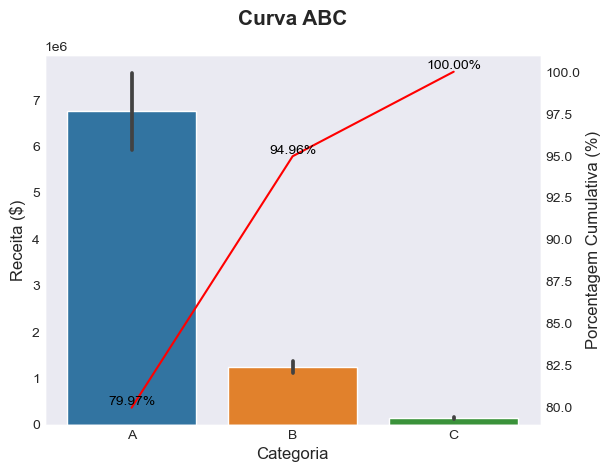

In [110]:
sns.set_style('dark')
sns.countplot(x='Categoria', data=vendas_ABC)
ax = sns.barplot(x='Categoria', y='Valor Total', data=vendas_ABC)
ax_2 = ax.twinx()
sns.lineplot(x='Categoria', y='Cumulativo', data=Categorias_receita, color='red', ax=ax_2)

for x, y in zip(Categorias_receita['Categoria'], Categorias_receita['Cumulativo']):
    ax_2.text(x, y, f'{y:.2f}%', color='black', ha='center', va='bottom')

plt.title('Curva ABC\n', fontsize=15, fontweight='bold')
ax_2.set_ylabel('Porcentagem Cumulativa (%)', fontsize=12)
ax.set_ylabel('Receita ($)', fontsize=12)
ax.set_xlabel('Categoria', fontsize=12) 

plt.show()

### - Receita  por categoria

In [112]:
Categorias_receita_total = vendas_ABC.groupby(['Categoria'])[['Valor Total']].sum().reset_index()
Categorias_receita_total

,Categoria,Valor Total
0,A,446570254
1,B,83699838
2,C,28129288


### - Código dos itens da categoria A

In [113]:
selecao = vendas_ABC.Categoria == 'A'
Itens_A = vendas_ABC[selecao]
Itens_A = Itens_A['cdProduto'].to_list()
Itens_A

[1421,
 1420,
 257,
 2422,
 2404,
 118,
 114,
 2549,
 2166,
 1759,
 292,
 176,
 1608,
 1607,
 1150,
 2494,
 691,
 878,
 2474,
 2262,
 1862,
 2613,
 2279,
 2025,
 1132,
 2223,
 1830,
 1600,
 304,
 1561,
 1560,
 2268,
 1049,
 665,
 2257,
 2476,
 2224,
 279,
 2282,
 2023,
 2227,
 283,
 2622,
 1484,
 2258,
 1151,
 661,
 2446,
 1521,
 1131,
 1389,
 1468,
 1170,
 492,
 1760,
 693,
 2577,
 2574,
 2481,
 702,
 440,
 438,
 2270,
 2226,
 2026,
 120]

### - Código dos itens da categoria C

In [114]:
selecao = vendas_ABC.Categoria == 'C'
Itens_C = vendas_ABC[selecao]
Itens_C = Itens_C['cdProduto'].to_list()
Itens_C

[2300,
 2064,
 1166,
 2584,
 2061,
 1943,
 2512,
 1967,
 2652,
 2504,
 2315,
 2601,
 2070,
 2060,
 2467,
 334,
 2066,
 2619,
 2228,
 1518,
 1722,
 2668,
 2069,
 1721,
 2505,
 187,
 2556,
 2461,
 1831,
 965,
 2452,
 2052,
 2309,
 694,
 469,
 2608,
 2667,
 272,
 392,
 2519,
 935,
 2097,
 231,
 2105,
 1841,
 258,
 191,
 2602,
 1556,
 1979,
 2485,
 2067,
 2558,
 1723,
 2151,
 2653,
 2620,
 2319,
 159,
 703,
 2301,
 2062,
 333,
 1491,
 896,
 2516,
 895,
 1597,
 2104,
 1206,
 468,
 2221,
 2672,
 514,
 2490,
 2435,
 695,
 2563,
 1073,
 771,
 1965,
 2491,
 2677,
 1939,
 2521,
 2464,
 462,
 1942,
 2106,
 2570,
 2573,
 1863,
 1989,
 2685,
 168,
 1783,
 2585,
 824,
 2057,
 2394,
 2463,
 476,
 829,
 2247,
 877,
 2623,
 467,
 830,
 2489,
 2396,
 2670,
 2058,
 487,
 1972,
 2318,
 2551,
 2073,
 2651,
 1377,
 1234,
 696,
 1086,
 2185,
 2191,
 1074,
 183,
 2107,
 2676,
 2202,
 1701,
 1399,
 2469,
 2538,
 2496,
 1378,
 2303,
 2059,
 2305,
 2627,
 2080,
 2409,
 741,
 1991,
 2633,
 2604,
 2671,
 2198,
 48

## Parte IV: Conclusão

### Como pode ser oberservado com os dados, 20% das mercadorias  vendidas foram responsáveis por 80% (precisamente 0,7997) da receita, seguindo o princípio de Pareto, totalizando 446.570.254,00 de um total de 558.399.380,00 ao longo do ano de 2019. 

### Os itens mais importantes, responsáveis por 80% da receita, são os seguintes:
 1421,
 1420,
 257,
 2422,
 2404,
 118,
 114,
 2549,
 2166,
 1759,
 292,
 176,
 1608,
 1607,
 1150,
 2494,
 691,
 878,
 2474,
 2262,
 1862,
 2613,
 2279,
 2025,
 1132,
 2223,
 1830,
 1600,
 304,
 1561,
 1560,
 2268,
 1049,
 665,
 2257,
 2476,
 2224,
 279,
 2282,
 2023,
 2227,
 283,
 2622,
 1484,
 2258,
 1151,
 661,
 2446,
 1521,
 1131,
 1389,
 1468,
 1170,
 492,
 1760,
 693,
 2577,
 2574,
 2481,
 702,
 440,
 438,
 2270,
 2226,
 2026,
 120.

### Os itens menos significativos, com apenas 5% da receita, são os seguintes: 
2300,
 2064,
 1166,
 2584,
 2061,
 1943,
 2512,
 1967,
 2652,
 2504,
 2315,
 2601,
 2070,
 2060,
 2467,
 334,
 2066,
 2619,
 2228,
 1518,
 1722,
 2668,
 2069,
 1721,
 2505,
 187,
 2556,
 2461,
 1831,
 965,
 2452,
 2052,
 2309,
 694,
 469,
 2608,
 2667,
 272,
 392,
 2519,
 935,
 2097,
 231,
 2105,
 1841,
 258,
 191,
 2602,
 1556,
 1979,
 2485,
 2067,
 2558,
 1723,
 2151,
 2653,
 2620,
 2319,
 159,
 703,
 2301,
 2062,
 333,
 1491,
 896,
 2516,
 895,
 1597,
 2104,
 1206,
 468,
 2221,
 2672,
 514,
 2490,
 2435,
 695,
 2563,
 1073,
 771,
 1965,
 2491,
 2677,
 1939,
 2521,
 2464,
 462,
 1942,
 2106,
 2570,
 2573,
 1863,
 1989,
 2685,
 168,
 1783,
 2585,
 824,
 2057,
 2394,
 2463,
 476,
 829,
 2247,
 877,
 2623,
 467,
 830,
 2489,
 2396,
 2670,
 2058,
 487,
 1972,
 2318,
 2551,
 2073,
 2651,
 1377,
 1234,
 696,
 1086,
 2185,
 2191,
 1074,
 183,
 2107,
 2676,
 2202,
 1701,
 1399,
 2469,
 2538,
 2496,
 1378,
 2303,
 2059,
 2305,
 2627,
 2080,
 2409,
 741,
 1991,
 2633,
 2604,
 2671,
 2198,
 481,
 2433,
 2407,
 2642,
 1602,
 2444,
 1259,
 483,
 1988,
 1925,
 2236,
 2306,
 1152,
 1470,
 1765,
 2635,
 2188,
 2592,
 2402,
 2193,
 1205,
 2307,
 1978,
 1204,
 2022,
 2535,
 2484,
 2527,
 2575,
 2533,
 1981,
 1139,
 1339,
 2075,
 2204,
 2203,
 2554,
 2285,
 2302,
 2655,
 2314,
 2317,
 2683,
 2284,
 1983,
 1737,
 1085,
 1207,
 2420,
 2654,
 2646,
 1987,
 2684.